In [153]:
import sys
sys.path.append("/Users/lanag/Downloads/svise-tutorials")
import svise
from functools import partial

import matplotlib.pyplot as plt
from matplotlib import rc
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchsde import sdeint as torchsdeint
from tqdm import tqdm

from svise import sde_learning, sdeint
import time
rc('text', usetex=False)
torch.set_default_dtype(torch.float64)

In [154]:
#load data
import pandas as pd
import numpy as np
Xdata = pd.read_csv('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/StochasticLorenz/Lorenz_x_stochastic_gamma1_noise_.csv',header=None)
#Xdata_value = Xdata.values[0:3000,12:15]
timelen = 3000
#tspan = pd.read_csv('/Users/lanag/Downloads/svise-tutorials2/comparison/Lorenztspan_gamma05.csv',header = None)
dt = 0.01
T = timelen*dt
#STD = np.std(Xdata_value, axis=0)
N = 20
tspan = np.linspace(0,T,int(T/dt))
d = 3

In [155]:
def generate_data(data_value, t_eval, train_persentage):
    data = dict(t=t_eval, true_state=data_value)
    data["y"] = data_value @ G
    data["y"] += torch.randn_like(data["y"]) @ G1 * std
    data["True"] = data_value
    data["train_t"] = data["t"]#[0:int(train_persentage*t_eval.shape[0])]
    data["train_y"] = data["y"]#[0:int(train_persentage*t_eval.shape[0])]
    data["valid_t"] = data["t"]#[int(train_persentage*t_eval.shape[0]):]
    data["valid_state"] = data["true_state"]#[int(train_persentage*t_eval.shape[0]):]
    data["train_state"] = data["true_state"]#[0:int(train_persentage*t_eval.shape[0])]
    return data

In [156]:
start = time.time()
Mu = np.empty((3000, 3)) 
Xobs = np.empty((3000, 3)) 
for i in range(N):
    Xdata_value = Xdata.values[0:3000,(i+1)*3-3:(i+1)*3]
    STD = np.std(Xdata_value, axis=0)
    Xdata_value = torch.tensor(Xdata_value).clone().detach()
    tspan = torch.tensor(tspan).clone().detach()
    G = torch.eye(3)
    G1 = torch.eye(3)*STD
    std = 0.3
    data = generate_data(Xdata_value, tspan, 0.8)
    t_span = (data["train_t"].min(), data["train_t"].max())
    d = 3 # dimension of the latent state
    degree = 2 # degree of polynomial terms
    n_reparam_samples = len(data["train_t"]) # how many reparam samples
    var = (torch.ones(d) * std) ** 2
    num_data = len(data["train_t"])
    
    model = sde_learning.SparsePolynomialSDE(
    d, 
    t_span, 
    degree=degree, 
    n_reparam_samples=n_reparam_samples, 
    G=G, 
    num_meas=d, 
    measurement_noise=var, 
    train_t=data["train_t"], 
    train_x=data["train_y"],
    input_labels=["x", "y", "z"],)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-1)
    batch_size = min(len(data['train_t']), 256)
    train_loader = DataLoader(TensorDataset(data["train_t"], data["train_y"]), batch_size=batch_size, shuffle=True)

    # sparse learning takes a long time to converge
    num_epochs = 50 #1000
    warmup_iters = num_epochs // 2

    j=0
    for epoch in tqdm(range(1,num_epochs+1)):
        j += 1
        beta = min(1.0, j / warmup_iters)
        for tbatch, ybatch in train_loader:
            optimizer.zero_grad()
            loss = -model.elbo(tbatch, ybatch, beta=beta,  N=num_data)
            #loss = model.elbo(nsde_args["train_t"], nsde_args["train_x"], beta=1.0, N = 100)
            loss.backward()
            optimizer.step()
    #model.cpu()
    #from copy import deepcopy as copy
    #recorded_models.append(model.state_dict())
    with torch.no_grad():
        model.eval()
        model.sde_prior.reset_sparse_index()
        model.sde_prior.update_sparse_index()
        var_names = ["x", "y", "z"]
        for j, eq in enumerate(model.sde_prior.feature_names):
            print(f"d{var_names[j]} = {eq}")
            
        state_true = data
        mu = model.marginal_sde.mean(state_true["t"])
        obsx = state_true["y"]
        Mu = np.concatenate((Mu, mu.detach().numpy()), axis=1)
        Xobs = np.concatenate((Xobs, obsx.detach().numpy()), axis=1)
end = time.time()

print('Time consuming:', end - start)

100%|███████████████████████████████████████████| 50/50 [03:11<00:00,  3.83s/it]
/var/folders/tx/qq1ds3m144q1b4ghn62l4kjc0000gn/T/ipykernel_91490/1929056187.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tspan = torch.tensor(tspan).clone().detach()


dx = 4.64y + -0.14x z
dy = 11.45x + 3.47y + -0.49x z + -0.14y z
dz = -6.35z + 0.69x y + 0.05y^2


100%|███████████████████████████████████████████| 50/50 [02:53<00:00,  3.47s/it]


dx = -2.01x + 4.80y + -0.14x z
dy = 8.04x + 4.47y + -0.47x z + -0.15y z
dz = 0.66x y + 0.06y^2


100%|███████████████████████████████████████████| 50/50 [02:52<00:00,  3.45s/it]


dx = -3.15x + 6.03y + -0.11x z + 0.02y z
dy = 5.47y + -0.27x z + -0.07y z
dz = -11.531 + -4.99z + 0.84x y + 0.02y^2


100%|███████████████████████████████████████████| 50/50 [02:52<00:00,  3.45s/it]


dx = 3.75y + -0.10x z
dy = 
dz = 0.34x y


100%|███████████████████████████████████████████| 50/50 [02:52<00:00,  3.44s/it]


dx = -0.88x + 5.18y + -0.11x z
dy = 
dz = -3.48z + 0.59x y


100%|███████████████████████████████████████████| 50/50 [02:51<00:00,  3.43s/it]


dx = 3.011 + -2.23x + 4.40y + -0.08x z + 0.01z^2
dy = 5.68x + 3.56y + -0.44x z + -0.04y z
dz = -21.441 + -2.81z + 0.06x^2 + 0.55x y + 0.03y^2


100%|███████████████████████████████████████████| 50/50 [02:52<00:00,  3.46s/it]


dx = 5.651 + -2.04x + 4.56y + -0.09x z
dy = 9.82x + 3.14y + -0.42x z + -0.10y z
dz = -5.71z + 0.08x^2 + 0.33x y + 0.18y^2 + 0.07z^2


100%|███████████████████████████████████████████| 50/50 [02:52<00:00,  3.45s/it]


dx = 3.86y + 0.61z + -0.06x y + -0.08x z
dy = -8.971 + 8.18x + 1.85y + -0.34x z + -0.05y z
dz = -0.16y + -3.48z + 0.56x y + 0.01x z


100%|███████████████████████████████████████████| 50/50 [02:56<00:00,  3.54s/it]


dx = -0.68x + 4.52y + -0.10x z
dy = -0.09x z
dz = -5.611 + -2.69z + 0.06x^2 + 0.15x y + 0.27y^2


100%|███████████████████████████████████████████| 50/50 [02:47<00:00,  3.34s/it]


dx = -6.62x + 7.91y + -0.01x z + -0.01y z
dy = -12.891 + 0.92x + 7.14y + -0.25x z + -0.16y z
dz = -20.261 + 1.05x + -1.09y + -4.58z + 0.67x y + 0.06y^2 + 0.03z^2


100%|███████████████████████████████████████████| 50/50 [02:43<00:00,  3.27s/it]


dx = 4.14y + -0.10x z
dy = 1.77y
dz = -3.12z + 0.37x y + 0.12y^2


100%|███████████████████████████████████████████| 50/50 [02:44<00:00,  3.28s/it]


dx = -8.42x + 8.18y + -0.27z + 0.04x^2
dy = 6.77y + -0.31x z + -0.02y^2 + -0.09y z
dz = -5.41z + 0.61x y + 0.07y^2


100%|███████████████████████████████████████████| 50/50 [02:43<00:00,  3.27s/it]


dx = -2.97x + 5.01y + -0.15x z
dy = 4.33y + -0.27x z
dz = -10.241 + -3.73z + 0.06x^2 + 0.50x y + 0.10y^2


100%|███████████████████████████████████████████| 50/50 [02:50<00:00,  3.42s/it]


dx = -0.74x + 4.26y + -0.10x z
dy = 5.07y + -0.27x z + -0.11y z
dz = -4.83z + 0.10x^2 + 0.68x y


100%|███████████████████████████████████████████| 50/50 [02:38<00:00,  3.16s/it]


dx = -1.02x + 4.90y + -0.14x z
dy = -7.871 + 4.18x + 4.13y + -0.36x z
dz = -3.311 + -3.81z + 0.66x y


100%|███████████████████████████████████████████| 50/50 [02:47<00:00,  3.35s/it]


dx = 4.11y + 0.10x^2 + -0.15x z
dy = 6.39x + 3.15y + -0.42x z + -0.04y z
dz = -14.541 + -4.06z + 0.04x^2 + 0.49x y + 0.08y^2


100%|███████████████████████████████████████████| 50/50 [02:58<00:00,  3.56s/it]


dx = -0.19x + 3.82y + 0.02x y + -0.11x z
dy = 7.12x + 1.68y + -0.34x z
dz = -8.931 + -3.70z + 0.55x y + 0.05y^2


100%|███████████████████████████████████████████| 50/50 [03:10<00:00,  3.80s/it]


dx = -6.29x + 6.15y
dy = 3.49x + 5.06y + -0.03x^2 + -0.34x z + -0.05y z
dz = -4.43z + 0.44x y + 0.11y^2


100%|███████████████████████████████████████████| 50/50 [02:46<00:00,  3.33s/it]


dx = -1.30x + 4.28y + -0.13x z
dy = 23.721 + 4.15x + 4.00y + -0.37x z + -0.02y z
dz = -19.691 + -3.94z + 0.73x y + 0.02y^2


100%|███████████████████████████████████████████| 50/50 [02:46<00:00,  3.34s/it]

dx = -1.46x + 3.55y + -0.02x z
dy = 
dz = 0.15y^2
Time consuming: 3454.4417831897736


In [157]:
model.eval()
model.sde_prior.reset_sparse_index()
model.sde_prior.update_sparse_index()
var_names = ["x", "y", "z"]
for j, eq in enumerate(model.sde_prior.feature_names):
    print(f"d{var_names[j]} = {eq}")

dx = -1.46x + 3.55y + -0.02x z
dy = 
dz = 0.15y^2


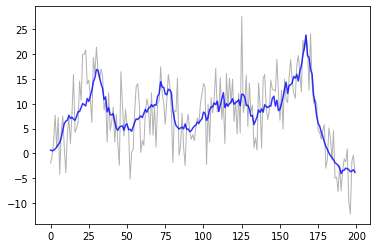

In [166]:
plt.plot(data["y"].numpy()[:200,0], "k-", label="training data", alpha=0.3, linewidth = 1)
plt.plot(data["True"].numpy()[:200,0], 'b-', label='latent state', alpha=0.8)

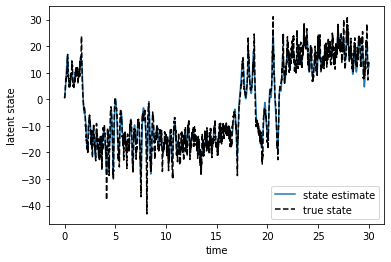

In [158]:
state_true = data
with torch.no_grad():
    # get the state estimate
    mu = model.marginal_sde.mean(state_true["train_t"])
    var = model.marginal_sde.K(state_true["train_t"]).diagonal(dim1=-2, dim2=-1)
    lb = mu - 2 * var.sqrt()
    ub = mu + 2 * var.sqrt()

fig, ax = plt.subplots()
ax.plot(state_true["t"].numpy(), mu.numpy()[:,0], 'C0', label='state estimate')
#ax.plot(state_true["train_t"].numpy(), mu.numpy()[:,1], 'C0')
ax.plot(state_true["t"].numpy(), state_true["true_state"].numpy()[:,0], 'k--', label='true state')
#ax.plot(state_true["t"].numpy(), state_true["true_state"].numpy()[:,1], 'k--')

ax.set_xlabel("time")
ax.set_ylabel("latent state")
ax.legend()

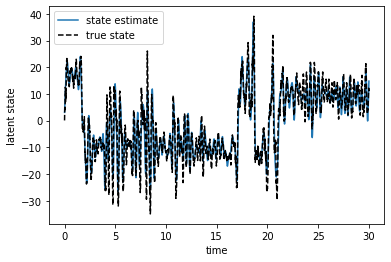

In [159]:
state_true = data
with torch.no_grad():
    # get the state estimate
    mu = model.marginal_sde.mean(state_true["t"])
    var = model.marginal_sde.K(state_true["t"]).diagonal(dim1=-2, dim2=-1)
    lb = mu - 2 * var.sqrt()
    ub = mu + 2 * var.sqrt()

# plot the results
fig, ax = plt.subplots()
ax.plot(state_true["t"].numpy(), mu.numpy()[:,1], 'C0', label='state estimate')
#ax.plot(state_true["train_t"].numpy(), mu.numpy()[:,1], 'C0')
ax.plot(state_true["t"].numpy(), state_true["true_state"].numpy()[:,1], 'k--', label='true state')
#ax.plot(state_true["t"].numpy(), state_true["true_state"].numpy()[:,1], 'k--')

ax.set_xlabel("time")
ax.set_ylabel("latent state")
ax.legend()
#plt.savefig('Lorenz_2nodes_noise075.pdf')

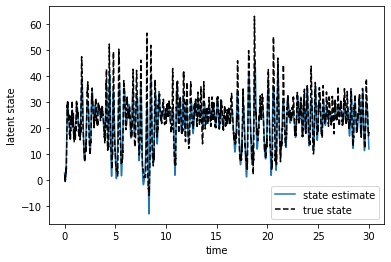

In [165]:
fig, ax = plt.subplots()
ax.plot(state_true["t"].numpy(), mu.numpy()[:,2], 'C0', label='state estimate')
#ax.plot(state_true["train_t"].numpy(), mu.numpy()[:,1], 'C0')
ax.plot(state_true["t"].numpy(), state_true["true_state"].numpy()[:,2], 'k--', label='true state')
#ax.plot(state_true["t"].numpy(), state_true["true_state"].numpy()[:,1], 'k--')

ax.set_xlabel("time")
ax.set_ylabel("latent state")
ax.legend()
#plt.savefig('Lorenz_2nodes_noise075.pdf')

In [161]:
#Result = np.concatenate((mu1,mu2,mu3,mu4,mu5), axis=1)

In [162]:
np.savetxt('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/StochasticLorenz/estimated_network_gamma1_noise30.csv', Mu[:,3:], delimiter=',')

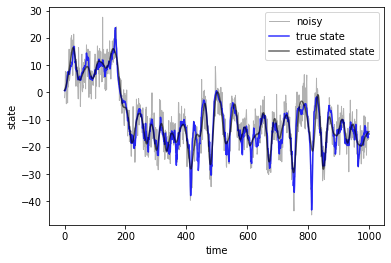

In [173]:
fig, ax = plt.subplots()
ax.plot(data["y"].numpy()[:1000,0], "k-", alpha=0.3, linewidth = 1, label='noisy')
ax.plot(data["True"].numpy()[:1000,0], 'b-', alpha=0.8, label='true state')
ax.plot(mu.numpy()[:1000,0], 'k-',alpha=0.6, label='estimated state')
ax.set_xlabel("time")
ax.set_ylabel("state")
ax.legend()
plt.savefig('denoise-SVISE.pdf')